In [1843]:
import pandas as pd
import numpy as np
import pylab as pl
from sklearn import linear_model
from sklearn import metrics
import statsmodels.formula.api as smf
import os
import sys
import geopandas as gp
import shapely

% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1844]:
remerge = gp.GeoDataFrame.from_csv('mergedv3.csv')

In [1845]:
# na values were created when an area without any speed bumps was added therefore fill with 0
remerge.fillna(0, inplace = True)

In [1846]:
mean_injured = remerge['NUMBER OF PERSONS INJURED'].mean()
std_injured = remerge['NUMBER OF PERSONS INJURED'].std()
mean_killed = remerge['NUMBER OF PERSONS KILLED'].mean()
std_killed = remerge['NUMBER OF PERSONS KILLED'].std()

In [1847]:
remerge['standardized_injuries'] = [(x - mean_injured) / std_injured for x in remerge['NUMBER OF PERSONS INJURED']]
remerge['standardized_death'] = [(x - mean_killed) / std_killed for x in remerge['NUMBER OF PERSONS KILLED']]

In [1848]:
injury_change = []
injury_change_2014 = remerge.groupby('Precinct')['standardized_injuries'].pct_change()
injury_change_2015 = remerge.groupby('Precinct')['standardized_injuries'].pct_change(periods = 2)
for x in range(len(remerge)):
    if remerge.iloc[x, 2] == 2013.0: 
        injury_change.append(0)
    elif remerge.iloc[x, 2] == 2014.0:
        injury_change.append(injury_change_2014[x])
    else:
        injury_change.append(injury_change_2015[x])
remerge['standardized_injuries_change'] = injury_change

In [1849]:
proj_corr = gp.GeoDataFrame.from_csv('street_improvement_project_corridors')
proj_inter = gp.GeoDataFrame.from_csv('street_improvement_project_intesections')

In [1850]:
proj_corr.head()

,precinct,Corridor_Proj_Total,type
0,1.0,0,Bicycle Network Dev
1,1.0,15,Bicycle Network Development
2,1.0,0,Bike Network Dev
3,1.0,0,High Crash Corridor
4,1.0,0,New Public Space


In [1851]:
pivoted = pd.pivot_table(proj_corr, index = 'precinct', columns = 'type', values = 'Corridor_Proj_Total', aggfunc = sum)

In [1852]:
pivoted['Bikes'] = pivoted['Bicycle Network Dev'] + pivoted['Bicycle Network Development'] + pivoted['Bike Network Dev']

In [1853]:
pivoted.drop(['Bicycle Network Dev', 'Bicycle Network Development', 'Bike Network Dev'], axis = 1, inplace = True)

In [1854]:
pivoted.columns = ['High_Crash_Corridor_c', u'New_Public_Space_c', u'Pedestrian_Safety_c',
       u'Senior_Safety_c', u'Traffic_Calming_c', u'Traffic_Network_Chng_c',
       u'VZ_Priority_Geo_c', u'Vision_Zero_c', u'Bikes_c']

In [1855]:
pivoted2 = pd.pivot_table(proj_inter, index = 'precinct', columns = 'type', values = 'Intersec_Proj_Total', aggfunc = sum)

In [1856]:
pivoted2.columns = ['High_Crash_Corridor_i', u'Pedestrian_Safety_i', u'Senior_Safety_i',
                   u'Traffic_Calming_i', u'Traffic_Network_Chng_i', u'VZ_Priority_Geo_i',
                   u'Vision_Zero_i']

In [1857]:
with_projects = pd.merge(remerge, pivoted, left_on = 'Precinct', right_index = True, how = 'outer')

with_projects = pd.merge(with_projects, pivoted2, left_on = 'Precinct', right_index = True, how = 'outer')

with_projects.fillna(0, inplace = True) # add in projects

In [1858]:
data = with_projects[with_projects.Year > 2013]

In [1859]:
eqt = ['Speed_Bump_Total', 'Neigh_Slow_Zone_Total', 'New_Public_Space_c',
        'Pedestrian_Safety_c', 'Senior_Safety_c', 'Traffic_Calming_c', 'Traffic_Network_Chng_c',
         'Bikes_c', 
        'Pedestrian_Safety_i', 'Senior_Safety_i', 'Traffic_Calming_i', 'Traffic_Network_Chng_i' ]
eqt = 'standardized_injuries_change ~ ' + ' + '.join(eqt)

In [1860]:
eqt

'standardized_injuries_change ~ Speed_Bump_Total + Neigh_Slow_Zone_Total + New_Public_Space_c + Pedestrian_Safety_c + Senior_Safety_c + Traffic_Calming_c + Traffic_Network_Chng_c + Bikes_c + Pedestrian_Safety_i + Senior_Safety_i + Traffic_Calming_i + Traffic_Network_Chng_i'

# Regression for change in standardized injuries v. safety

In [1861]:
lm = smf.ols(eqt, data).fit() # just post vision zero data v. change in standardized injuries

In [1862]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     standardized_injuries_change   R-squared:                       0.079
Model:                                      OLS   Adj. R-squared:                  0.001
Method:                           Least Squares   F-statistic:                     1.011
Date:                          Fri, 09 Dec 2016   Prob (F-statistic):              0.442
Time:                                  14:41:10   Log-Likelihood:                -266.55
No. Observations:                           154   AIC:                             559.1
Df Residuals:                               141   BIC:                             598.6
Df Model:                                    12                                         
Covariance Type:                      nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  0.1317      0.202      0.652      0.516        -0.268     0.531
Speed_Bump_Total          -0.0183      0.027     -0.682      0.496        -0.071     0.035
Neigh_Slow_Zone_Total     -0.1873      0.345     -0.543      0.588        -0.869     0.494
New_Public_Space_c         0.0468      0.256      0.183      0.855        -0.459     0.553
Pedestrian_Safety_c       -0.0646      0.046     -1.391      0.166        -0.156     0.027
Senior_Safety_c           -0.1329      1.031     -0.129      0.898        -2.172     1.906
Traffic_Calming_c         -0.0037      0.008     -0.474      0.636        -0.019     0.012
Traffic_Network_Chng_c    -0.0655      0.064     -1.023      0.308        -0.192     0.061
Bikes_c                    0.1168      0.046      2.558      0.012         0.027     0.207
Pedestrian_Safety_i        0.1005      0.137      0.733      0.465        -0.170     0.372
Senior_Safety_i            0.0934      1.321      0.071      0.944        -2.518     2.705
Traffic_Calming_i          0.1151      0.144      0.797      0.427        -0.170     0.400
Traffic_Network_Chng_i    -0.8786      0.637     -1.378      0.170        -2.139     0.382
==============================================================================
Omnibus:                       50.339   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              866.506
Skew:                           0.553   Prob(JB):                    6.93e-189
Kurtosis:                      14.568   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Change in standardized Injuries v. All Street Redesign Variables. Not so useful. Therefore, add in the total population and area

In [1863]:
#precincts = gp.GeoDataFrame.from_file(os.getenv('HOME') + '/Applied_Data_Science/VZ_data/Precincts/summary_police_precincts.shp')

In [1864]:
'''#precincts_shp = precincts.drop([u'Ages_10_to', u'Ages_15_to', u'Ages_18_an', u'Ages_20_to',
       u'Ages_25_to', u'Ages_45_to', u'Ages_5_to_', u'Ages_65_an',
       u'Ages_Under',    u'SUM_ASZ', u'SUM_BikeFa',
       u'SUM_BikeIn', u'SUM_Fatali', u'SUM_Injuri',    u'SUM_LPI',
       u'SUM_MVOFat', u'SUM_MVOInj', u'SUM_NeighS', u'SUM_PedFat',
       u'SUM_PedInj', u'SUM_SIPCor', u'SUM_SIPInt', u'SUM_Signal',
       u'SUM_SpeedH', u'SUM_VZ_P_1', u'SUM_VZ_P_2', u'SUM_VZ_Pri'], axis = 1)
       '''

"#precincts_shp = precincts.drop([u'Ages_10_to', u'Ages_15_to', u'Ages_18_an', u'Ages_20_to',\n       u'Ages_25_to', u'Ages_45_to', u'Ages_5_to_', u'Ages_65_an',\n       u'Ages_Under',    u'SUM_ASZ', u'SUM_BikeFa',\n       u'SUM_BikeIn', u'SUM_Fatali', u'SUM_Injuri',    u'SUM_LPI',\n       u'SUM_MVOFat', u'SUM_MVOInj', u'SUM_NeighS', u'SUM_PedFat',\n       u'SUM_PedInj', u'SUM_SIPCor', u'SUM_SIPInt', u'SUM_Signal',\n       u'SUM_SpeedH', u'SUM_VZ_P_1', u'SUM_VZ_P_2', u'SUM_VZ_Pri'], axis = 1)\n       "

In [1865]:
#precincts_shp.Shape_Area = precincts_shp.Shape_Area / (2.788 * 10 ** 7) # convert shape area to miles

In [1866]:
#precincts_shp.Precint = precincts_shp.Precinct.astype(float)

In [1867]:
#with_projects = pd.merge(precincts_shp, with_projects, left_on = 'Precinct', right_on = 'Precinct') #add in precincts

In [1868]:
regress = ['Speed_Bump_Total', 'Neigh_Slow_Zone_Total', 'New_Public_Space_c',
        'Pedestrian_Safety_c', 'Senior_Safety_c', 'Traffic_Calming_c', 'Traffic_Network_Chng_c',
        'Bikes_c', 'Pedestrian_Safety_i', 'Senior_Safety_i', 'Traffic_Calming_i', 'Traffic_Network_Chng_i']
eqt = 'Injuries_Per_Thou ~ ' + ' + '.join(regress)

In [1869]:
with_projects_area = with_projects

In [1870]:
with_projects_area.loc[:,'High_Crash_Corridor_c':'Vision_Zero_i'] = with_projects_area.loc[:,'High_Crash_Corridor_c':'Vision_Zero_i'].apply(lambda x: x / with_projects_area.Shape_Area)

In [1871]:
with_projects_area.loc[:, 'Neigh_Slow_Zone_Total':'Speed_Bump_Total'] = with_projects_area.loc[:, 'Neigh_Slow_Zone_Total':'Speed_Bump_Total'].apply(lambda x: x / with_projects_area.Shape_Area)

# Note that some areas have outlier populations. Remove from further analysis those areas more than 2 standard deviations below the mean as they do not have enough population for data to be accurate. 

In [1872]:
std_pop = with_projects.Total_Pop.std()
mean_pop = with_projects.Total_Pop.mean()
threshold = -2 * std_pop + mean_pop

In [1873]:
# removes a handful of outlier precints with v low populations (ie Central Park)
data4 = with_projects[with_projects.Total_Pop > threshold]

In [1874]:
lm4 = smf.ols(eqt, data = data4).fit()
lm4.summary() #Injuries per thousand v all variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Injuries_Per_Thou   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     4.189
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           6.53e-06
Time:                        14:41:11   Log-Likelihood:                -551.33
No. Observations:                 225   AIC:                             1129.
Df Residuals:                     212   BIC:                             1173.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  5.6085      0.284     19.767      0.000         5.049     6.168
Speed_Bump_Total          -0.2098      0.089     -2.357      0.019        -0.385    -0.034
Neigh_Slow_Zone_Total      0.1555      0.965      0.161      0.872        -1.746     2.057
New_Public_Space_c         0.7173      0.995      0.721      0.472        -1.243     2.678
Pedestrian_Safety_c       -0.0200      0.104     -0.192      0.848        -0.225     0.185
Senior_Safety_c           -1.9912      1.678     -1.186      0.237        -5.300     1.317
Traffic_Calming_c          0.0671      0.029      2.318      0.021         0.010     0.124
Traffic_Network_Chng_c     0.2195      0.183      1.198      0.232        -0.142     0.580
Bikes_c                    0.4185      0.087      4.784      0.000         0.246     0.591
Pedestrian_Safety_i        0.0410      0.240      0.171      0.865        -0.432     0.514
Senior_Safety_i          -17.1207     12.975     -1.320      0.188       -42.697     8.455
Traffic_Calming_i         -0.9337      0.421     -2.218      0.028        -1.764    -0.104
Traffic_Network_Chng_i     3.2573      1.701      1.915      0.057        -0.096     6.611
==============================================================================
Omnibus:                      215.542   Durbin-Watson:                   0.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5157.226
Skew:                           3.756   Prob(JB):                         0.00
Kurtosis:                      25.219   Cond. No.                         665.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1875]:
data4.head()

,PrecinctYear,Precinct,Year,Taxis,Flyers,Seniors,Outreach,HandsOn,Edu_Total,Backing Unsafely,...,VZ_Priority_Geo_c,Vision_Zero_c,Bikes_c,High_Crash_Corridor_i,Pedestrian_Safety_i,Senior_Safety_i,Traffic_Calming_i,Traffic_Network_Chng_i,VZ_Priority_Geo_i,Vision_Zero_i
0,682013,68.0,2013,0,0,0,0,0,0,9,...,1.759130,17.088689,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,682014,68.0,2014,0,0,4,4,0,8,9,...,1.759130,17.088689,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,682015,68.0,2015,4,0,3,11,2,20,2,...,1.759130,17.088689,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1022013,102.0,2013,0,0,0,0,0,0,19,...,1.254778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.418259,0.0
4,1022014,102.0,2014,0,4,4,7,1,16,20,...,1.254778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.418259,0.0


# Injuries per thousand with variables squared by precinct size in square miles

In [1876]:
data5 = with_projects_area[with_projects_area.Total_Pop > threshold]
lm5 = smf.ols(eqt, data = data5).fit()
lm5.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Injuries_Per_Thou   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     4.189
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           6.53e-06
Time:                        14:41:11   Log-Likelihood:                -551.33
No. Observations:                 225   AIC:                             1129.
Df Residuals:                     212   BIC:                             1173.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  5.6085      0.284     19.767      0.000         5.049     6.168
Speed_Bump_Total          -0.2098      0.089     -2.357      0.019        -0.385    -0.034
Neigh_Slow_Zone_Total      0.1555      0.965      0.161      0.872        -1.746     2.057
New_Public_Space_c         0.7173      0.995      0.721      0.472        -1.243     2.678
Pedestrian_Safety_c       -0.0200      0.104     -0.192      0.848        -0.225     0.185
Senior_Safety_c           -1.9912      1.678     -1.186      0.237        -5.300     1.317
Traffic_Calming_c          0.0671      0.029      2.318      0.021         0.010     0.124
Traffic_Network_Chng_c     0.2195      0.183      1.198      0.232        -0.142     0.580
Bikes_c                    0.4185      0.087      4.784      0.000         0.246     0.591
Pedestrian_Safety_i        0.0410      0.240      0.171      0.865        -0.432     0.514
Senior_Safety_i          -17.1207     12.975     -1.320      0.188       -42.697     8.455
Traffic_Calming_i         -0.9337      0.421     -2.218      0.028        -1.764    -0.104
Traffic_Network_Chng_i     3.2573      1.701      1.915      0.057        -0.096     6.611
==============================================================================
Omnibus:                      215.542   Durbin-Watson:                   0.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5157.226
Skew:                           3.756   Prob(JB):                         0.00
Kurtosis:                      25.219   Cond. No.                         665.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_sig = mf.ols('Injuries_Per_Thou')

# Injuries per thousand v. just speed bumps and neighborhood slow zones

In [1877]:
lm6 = smf.ols('Injuries_Per_Thou ~ Speed_Bump_Total + Neigh_Slow_Zone_Total', data = data5).fit()
lm6.summary() # just the more easily quanitifiable speed bump and neighborhood slow zone totals

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Injuries_Per_Thou   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.114
Date:                Fri, 09 Dec 2016   Prob (F-statistic):             0.0464
Time:                        14:41:11   Log-Likelihood:                -572.16
No. Observations:                 225   AIC:                             1150.
Df Residuals:                     222   BIC:                             1161.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 6.1455      0.257     23.911      0.000         5.639     6.652
Speed_Bump_Total         -0.2244      0.090     -2.492      0.013        -0.402    -0.047
Neigh_Slow_Zone_Total     0.9497      0.986      0.963      0.337        -0.994     2.893
==============================================================================
Omnibus:                      232.331   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6807.389
Skew:                           4.141   Prob(JB):                         0.00
Kurtosis:                      28.642   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1878]:
'''# merge data for group since per capita seems to be the way to go
merge2['PrecinctYear'] = merge2['PrecinctYear'].apply(lambda x: str(x).zfill(7))
remerge = pd.merge(merge2, precincts_shp, left_on = 'Precinct', right_on = 'Precinct', how = 'outer')
remerge.fillna(0, inplace = True)
remerge['Injuries_Per_Thou'] = remerge['NUMBER OF PERSONS INJURED'] / (remerge['Total_Pop'] / 1000)
remerge.to_csv('mergedv3.csv')
'''

"# merge data for group since per capita seems to be the way to go\nmerge2['PrecinctYear'] = merge2['PrecinctYear'].apply(lambda x: str(x).zfill(7))\nremerge = pd.merge(merge2, precincts_shp, left_on = 'Precinct', right_on = 'Precinct', how = 'outer')\nremerge.fillna(0, inplace = True)\nremerge['Injuries_Per_Thou'] = remerge['NUMBER OF PERSONS INJURED'] / (remerge['Total_Pop'] / 1000)\nremerge.to_csv('mergedv3.csv')\n"

Feature Selection for P-Values under threshold of 0.05

In [1879]:
sig_var = lm5.pvalues[lm5.pvalues < .1].keys()

In [1880]:
sig_eqt = 'Injuries_Per_Thou ~ ' + ' + '.join(sig_var[1:])

In [1881]:
sig_eqt

'Injuries_Per_Thou ~ Speed_Bump_Total + Traffic_Calming_c + Bikes_c + Traffic_Calming_i + Traffic_Network_Chng_i'

In [1882]:
lm_sig = smf.ols(sig_eqt, data5).fit()

In [1883]:
lm_sig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Injuries_Per_Thou   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     9.044
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           7.84e-08
Time:                        14:41:11   Log-Likelihood:                -554.15
No. Observations:                 225   AIC:                             1120.
Df Residuals:                     219   BIC:                             1141.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  5.6258      0.274     20.542      0.000         5.086     6.166
Speed_Bump_Total          -0.1910      0.078     -2.458      0.015        -0.344    -0.038
Traffic_Calming_c          0.0597      0.028      2.154      0.032         0.005     0.114
Bikes_c                    0.4003      0.083      4.795      0.000         0.236     0.565
Traffic_Calming_i         -0.9087      0.381     -2.382      0.018        -1.661    -0.157
Traffic_Network_Chng_i     3.3876      1.626      2.084      0.038         0.184     6.592
==============================================================================
Omnibus:                      212.773   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4888.119
Skew:                           3.699   Prob(JB):                         0.00
Kurtosis:                      24.603   Cond. No.                         83.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# All coefficients have a positive relationship with Total Injuries except for Traffic Calming at Intersections. This equation may be capturing a reverse relation where these strategies are deployed in areas that need them (good!)

In [1884]:
percent_change = []
perc_change_2014 = with_projects_area.groupby('Precinct').Injuries_Per_Thou.pct_change()
perc_change_2015 = with_projects_area.groupby('Precinct').Injuries_Per_Thou.pct_change(2)
for x in range(len(with_projects_area)):
    if with_projects_area.Year[x] == 2013:
        percent_change.append(0)
    elif with_projects_area.Year[x] == 2014: 
        percent_change.append(perc_change_2014[x])
    else:
        percent_change.append(perc_change_2015[x])
with_projects_area['Per_Thou_Inj_Change']  = percent_change

# Try Regressing Based on Percent Change in Per Capita Injuries. Therefore remove 2013 data as it is baseline

In [1885]:
data6 = with_projects_area[with_projects_area.Total_Pop > threshold][with_projects_area.Year > 2013]

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [1886]:
eqt_change = 'Per_Thou_Inj_Change ~ ' + ' + '.join(regress)

In [1887]:
lm_change = smf.ols(eqt_change, data6).fit()
lm_change.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.110
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     1.409
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):              0.169
Time:                         14:41:12   Log-Likelihood:                 161.96
No. Observations:                  150   AIC:                            -297.9
Df Residuals:                      137   BIC:                            -258.8
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -0.0618      0.011     -5.737      0.000        -0.083    -0.040
Speed_Bump_Total          -0.0070      0.003     -2.348      0.020        -0.013    -0.001
Neigh_Slow_Zone_Total      0.0007      0.031      0.022      0.982        -0.060     0.062
New_Public_Space_c        -0.0285      0.036     -0.786      0.433        -0.100     0.043
Pedestrian_Safety_c       -0.0056      0.004     -1.469      0.144        -0.013     0.002
Senior_Safety_c           -0.1154      0.061     -1.885      0.061        -0.236     0.006
Traffic_Calming_c          0.0007      0.001      0.664      0.508        -0.001     0.003
Traffic_Network_Chng_c    -0.0060      0.007     -0.904      0.367        -0.019     0.007
Bikes_c                   -0.0031      0.003     -0.967      0.335        -0.009     0.003
Pedestrian_Safety_i        0.0127      0.009      1.446      0.150        -0.005     0.030
Senior_Safety_i           -0.2258      0.474     -0.476      0.635        -1.164     0.712
Traffic_Calming_i          0.0007      0.015      0.044      0.965        -0.030     0.031
Traffic_Network_Chng_i     0.0432      0.061      0.704      0.483        -0.078     0.164
==============================================================================
Omnibus:                        2.349   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.309   Jarque-Bera (JB):                2.088
Skew:                           0.288   Prob(JB):                        0.352
Kurtosis:                       3.052   Cond. No.                         676.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1888]:
mean_per_thou_inj = data6.Injuries_Per_Thou.mean()

In [1889]:
danger_precincts = list(data5[data5.Year == 2013][data5.Injuries_Per_Thou > mean_per_thou_inj].Precinct)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [1890]:
data7 = data6[data6.Precinct.isin(danger_precincts)]

# Run analysis on dangerous precincts (described as precincts with pre vision zero deaths above the mean

In [1891]:
lm_danger = smf.ols(eqt, data6[data6.Precinct.isin(danger_precincts)]).fit()
lm_danger.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Injuries_Per_Thou   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     20.42
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           2.34e-16
Time:                        14:41:12   Log-Likelihood:                -134.33
No. Observations:                  72   AIC:                             292.7
Df Residuals:                      60   BIC:                             320.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  7.1488      0.340     20.997      0.000         6.468     7.830
Speed_Bump_Total          -0.1362      0.099     -1.370      0.176        -0.335     0.063
Neigh_Slow_Zone_Total      0.5373      1.022      0.526      0.601        -1.508     2.583
New_Public_Space_c        -0.3567      0.735     -0.485      0.629        -1.827     1.113
Pedestrian_Safety_c        0.4616      0.199      2.315      0.024         0.063     0.861
Senior_Safety_c           -1.2770      1.252     -1.020      0.312        -3.780     1.226
Traffic_Calming_c         -0.0224      0.029     -0.765      0.447        -0.081     0.036
Traffic_Network_Chng_c    -0.0105      0.137     -0.077      0.939        -0.285     0.264
Bikes_c                   -0.2880      0.083     -3.450      0.001        -0.455    -0.121
Pedestrian_Safety_i       11.0000      0.923     11.921      0.000         9.154    12.846
Senior_Safety_i        -1.458e-15   9.94e-16     -1.466      0.148     -3.45e-15  5.31e-16
Traffic_Calming_i          0.5567      0.522      1.067      0.290        -0.487     1.601
Traffic_Network_Chng_i     3.7120      1.544      2.405      0.019         0.624     6.800
==============================================================================
Omnibus:                        7.842   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               11.675
Skew:                          -0.346   Prob(JB):                      0.00292
Kurtosis:                       4.848   Cond. No.                     1.55e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.94e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1892]:
sig_var_danger = lm_danger.pvalues[lm_danger.pvalues < .05].keys() 
sig_eqt_danger = 'Injuries_Per_Thou ~ ' + ' + '.join(sig_var_danger[1:])
lm_sig_danger = smf.ols(sig_eqt_danger, data6[data6.Precinct.isin(danger_precincts)]).fit()
lm_sig_danger.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Injuries_Per_Thou   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     56.89
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           7.67e-21
Time:                        14:41:12   Log-Likelihood:                -137.07
No. Observations:                  72   AIC:                             284.1
Df Residuals:                      67   BIC:                             295.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  6.7290      0.224     30.021      0.000         6.282     7.176
Pedestrian_Safety_c        0.4501      0.183      2.462      0.016         0.085     0.815
Bikes_c                   -0.2710      0.079     -3.409      0.001        -0.430    -0.112
Pedestrian_Safety_i       11.1017      0.866     12.816      0.000         9.373    12.831
Traffic_Network_Chng_i     4.4947      1.317      3.412      0.001         1.866     7.124
==============================================================================
Omnibus:                        3.971   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                4.504
Skew:                          -0.059   Prob(JB):                        0.105
Kurtosis:                       4.220   Cond. No.                         25.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1975]:
danger_change_lm = smf.ols(eqt_change, data7).fit()
danger_change_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.331
Model:                             OLS   Adj. R-squared:                  0.208
Method:                  Least Squares   F-statistic:                     2.698
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):            0.00689
Time:                         16:47:10   Log-Likelihood:                 93.030
No. Observations:                   72   AIC:                            -162.1
Df Residuals:                       60   BIC:                            -134.7
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -0.0241      0.014     -1.666      0.101        -0.053     0.005
Speed_Bump_Total          -0.0122      0.004     -2.880      0.006        -0.021    -0.004
Neigh_Slow_Zone_Total      0.0128      0.043      0.294      0.770        -0.074     0.100
New_Public_Space_c        -0.0481      0.031     -1.538      0.129        -0.111     0.014
Pedestrian_Safety_c        0.0008      0.008      0.089      0.930        -0.016     0.018
Senior_Safety_c           -0.1382      0.053     -2.597      0.012        -0.245    -0.032
Traffic_Calming_c         -0.0010      0.001     -0.770      0.445        -0.003     0.002
Traffic_Network_Chng_c    -0.0066      0.006     -1.138      0.260        -0.018     0.005
Bikes_c                   -0.0041      0.004     -1.143      0.258        -0.011     0.003
Pedestrian_Safety_i       -0.0256      0.039     -0.653      0.516        -0.104     0.053
Senior_Safety_i        -7.191e-17   4.23e-17     -1.701      0.094     -1.56e-16  1.27e-17
Traffic_Calming_i         -0.0227      0.022     -1.023      0.310        -0.067     0.022
Traffic_Network_Chng_i     0.0918      0.066      1.399      0.167        -0.039     0.223
==============================================================================
Omnibus:                        0.383   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.826   Jarque-Bera (JB):                0.192
Skew:                           0.126   Prob(JB):                        0.908
Kurtosis:                       3.018   Cond. No.                     1.55e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.94e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1976]:
sig_var_danger_change = danger_change_lm.pvalues[danger_change_lm.pvalues < .1].keys() 
sig_eqt_danger_change = 'Per_Thou_Inj_Change ~ ' + ' + '.join(sig_var_danger_change)
lm_sig_danger_change = smf.ols(sig_eqt_danger_change, data7).fit()
lm_sig_danger_change.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.197
Model:                             OLS   Adj. R-squared:                  0.174
Method:                  Least Squares   F-statistic:                     8.457
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):           0.000519
Time:                         16:47:22   Log-Likelihood:                 86.456
No. Observations:                   72   AIC:                            -166.9
Df Residuals:                       69   BIC:                            -160.1
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0440      0.012     -3.579      0.001        -0.069    -0.019
Speed_Bump_Total    -0.0117      0.004     -3.215      0.002        -0.019    -0.004
Senior_Safety_c     -0.1428      0.052     -2.737      0.008        -0.247    -0.039
Senior_Safety_i           0          0        nan        nan             0         0
==============================================================================
Omnibus:                        1.201   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.549   Jarque-Bera (JB):                1.253
Skew:                           0.284   Prob(JB):                        0.534
Kurtosis:                       2.691   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# The change in per capita injuries cannot be explained by these factors

In [1895]:
precincts = gp.GeoDataFrame.from_file(os.getenv('HOME') + '/Applied_Data_Science/VZ_data/Precincts/summary_police_precincts.shp')

In [1896]:
precinct_geom = precincts.geometry

In [1897]:
with_proj_2014 = with_projects_area[with_projects_area.Year == 2014]
with_proj_2015 = with_projects_area[with_projects_area.Year == 2015]
with_proj_2014 = with_proj_2014.sort_values('Precinct')
with_proj_2015 = with_proj_2015.sort_values('Precinct')
with_proj_2014.reset_index(inplace = True)
with_proj_2015.reset_index(inplace = True)


In [1898]:
with_proj_2014 = gp.GeoDataFrame(with_proj_2014, geometry = precinct_geom)
with_proj_2015 = gp.GeoDataFrame(with_proj_2015, geometry = precinct_geom)

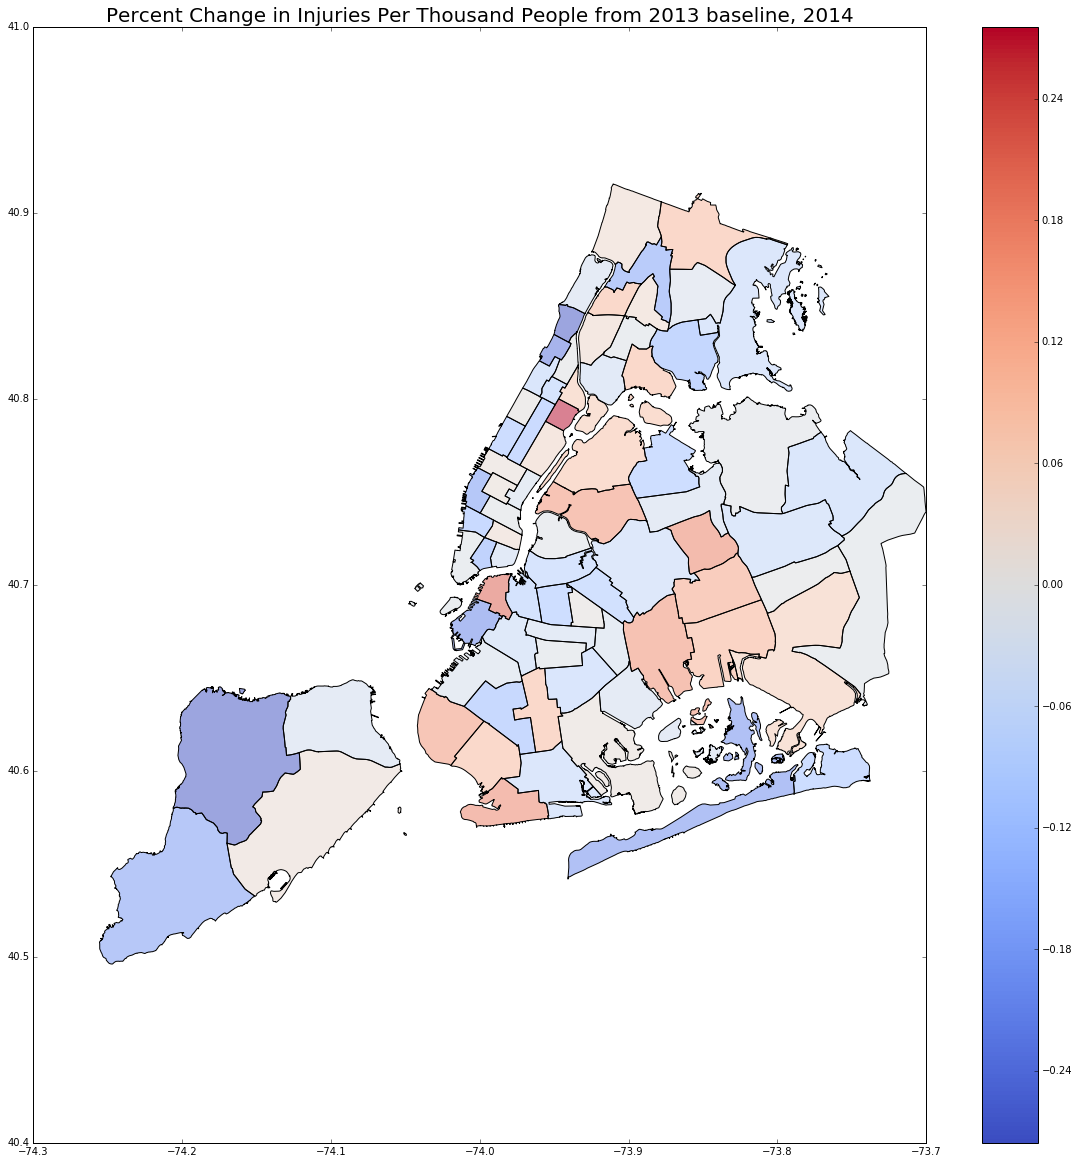

In [1970]:
fig, ax = plt.subplots(figsize = (20, 20))
with_proj_2014.plot(column = 'Per_Thou_Inj_Change', cmap = cm.coolwarm, ax = ax)

normalize = matplotlib.colors.Normalize(vmin = with_proj_2014.Per_Thou_Inj_Change.min(),
                                         vmax = -with_proj_2014.Per_Thou_Inj_Change.min())
colormap = cm.coolwarm
scalarmappable = cm.ScalarMappable(norm = normalize, cmap = colormap)
scalarmappable.set_array(with_proj_2014.Per_Thou_Inj_Change)
pl.colorbar(scalarmappable, ax = ax)
pl.title('Percent Change in Injuries Per Thousand People from 2013 baseline, 2014', fontsize = 20)
pl.savefig('2014_Changes.png', format = 'png')

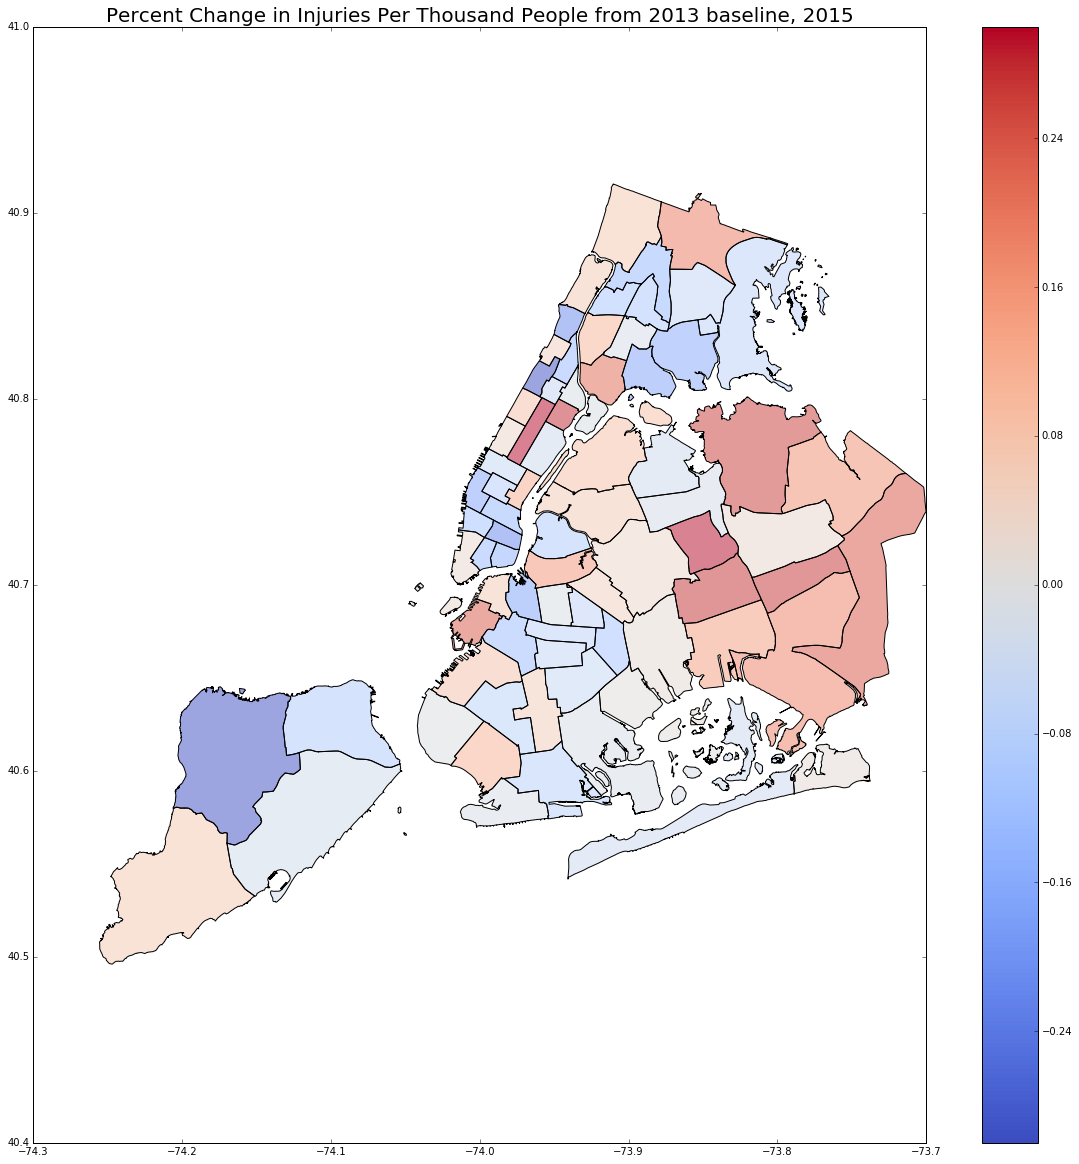

In [1967]:
fig, ax = plt.subplots(figsize = (20, 20))
with_proj_2015.plot(column = 'Per_Thou_Inj_Change', cmap = cm.coolwarm, ax = ax)
normalize = matplotlib.colors.Normalize(vmin = with_proj_2015.Per_Thou_Inj_Change.min(),
                                         vmax = -with_proj_2015.Per_Thou_Inj_Change.min())
colormap = cm.coolwarm
scalarmappable = cm.ScalarMappable(norm = normalize, cmap = colormap)
scalarmappable.set_array(with_proj_2015.Per_Thou_Inj_Change)
pl.colorbar(scalarmappable, ax = ax)
pl.title('Percent Change in Injuries Per Thousand People from 2013 baseline, 2015', fontsize = 20)
pl.savefig('2015_Changes.png', format = 'png')

Descriptive Stats: A text summary. 75 of 77 precincts have large enough populations to accurately categorize their injuries per thousand. In 2014, there was a mean decrease of 8.07% and a maximum decrease of 27.56% and in 2015, a mean decrease of 8.55% and a max decrease of 30%. While most precincts experienced a decline injuries, 14 precincts experienced increases. The largest increase was 13.87% and 11.9% in 2014 and 2015 respectively. 9 Precincts experienced an increase in injuries 

In [1901]:
with_proj_2014[with_proj_2014.Total_Pop > threshold].Per_Thou_Inj_Change.describe()

count    75.000000
mean     -0.080730
std       0.080771
min      -0.275568
25%      -0.125937
50%      -0.085484
75%      -0.043452
max       0.138790
Name: Per_Thou_Inj_Change, dtype: float64

In [1902]:
with_proj_2015[with_proj_2015.Total_Pop > threshold].Per_Thou_Inj_Change.describe()

count    75.000000
mean     -0.085588
std       0.094068
min      -0.300000
25%      -0.152297
50%      -0.101341
75%      -0.035410
max       0.119306
Name: Per_Thou_Inj_Change, dtype: float64

In [1903]:
print len(with_proj_2015[with_proj_2015.Per_Thou_Inj_Change > 0]) 
print len(with_proj_2014[with_proj_2014.Per_Thou_Inj_Change > 0])

14
14


In [1942]:
with_projects_area.Per_Thou_Inj_Change.std()

0.081980264201165373

In [1945]:
with_projects_area.Per_Thou_Inj_Change.mean()

-0.054630556111933577

In [1951]:
diff_by_year = pd.concat([with_proj_2014.Precinct, with_proj_2014.Per_Thou_Inj_Change, with_proj_2015.Per_Thou_Inj_Change], axis = 1)

In [1960]:
diff_by_year.columns = ['Precint', '2014_Change', '2015_Change']
#diff_by_year[diff_by_year['2014_Change'] > 0][diff_by_year['2015_Change'] < 0]
diff_by_year[diff_by_year['2014_Change'] < 0][diff_by_year['2015_Change'] > 0]

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,Precint,2014_Change,2015_Change
12,22.0,-0.158537,0.121951
22,40.0,-0.102215,0.063032
47,76.0,-0.229391,0.078853
55,90.0,-0.129454,0.021378
60,103.0,-0.070950,0.103079
62,105.0,-0.077699,0.079478
66,109.0,-0.075489,0.097856
68,111.0,-0.119293,0.029455
70,113.0,-0.020202,0.042424


In [2088]:
data7['Pop_Dens'] = data7.Total_Pop/data7.Shape_Area / 1000
eqt_with_pop = eqt_change + '+ Pop_Dens'
lm_danger2 = smf.ols(eqt_with_pop, data7).fit()
lm_danger2.summary()

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.353
Model:                             OLS   Adj. R-squared:                  0.221
Method:                  Least Squares   F-statistic:                     2.682
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):            0.00602
Time:                         20:41:38   Log-Likelihood:                 94.238
No. Observations:                   72   AIC:                            -162.5
Df Residuals:                       59   BIC:                            -132.9
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -0.0044      0.020     -0.218      0.828        -0.044     0.036
Speed_Bump_Total          -0.0111      0.004     -2.598      0.012        -0.020    -0.003
Neigh_Slow_Zone_Total      0.0079      0.043      0.183      0.856        -0.079     0.094
New_Public_Space_c        -0.0504      0.031     -1.626      0.109        -0.113     0.012
Pedestrian_Safety_c        0.0031      0.009      0.365      0.716        -0.014     0.020
Senior_Safety_c           -0.1378      0.053     -2.611      0.011        -0.243    -0.032
Traffic_Calming_c         -0.0002      0.001     -0.144      0.886        -0.003     0.003
Traffic_Network_Chng_c    -0.0045      0.006     -0.760      0.450        -0.016     0.007
Bikes_c                   -0.0036      0.004     -1.004      0.319        -0.011     0.004
Pedestrian_Safety_i       -0.0385      0.040     -0.964      0.339        -0.118     0.041
Senior_Safety_i        -3.421e-17   1.66e-17     -2.055      0.044     -6.75e-17 -8.95e-19
Traffic_Calming_i         -0.0273      0.022     -1.226      0.225        -0.072     0.017
Traffic_Network_Chng_i     0.0953      0.065      1.463      0.149        -0.035     0.226
Pop_Dens                  -0.0007      0.000     -1.419      0.161        -0.002     0.000
==============================================================================
Omnibus:                        0.320   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.852   Jarque-Bera (JB):                0.036
Skew:                           0.009   Prob(JB):                        0.982
Kurtosis:                       3.108   Cond. No.                     4.90e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.66e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

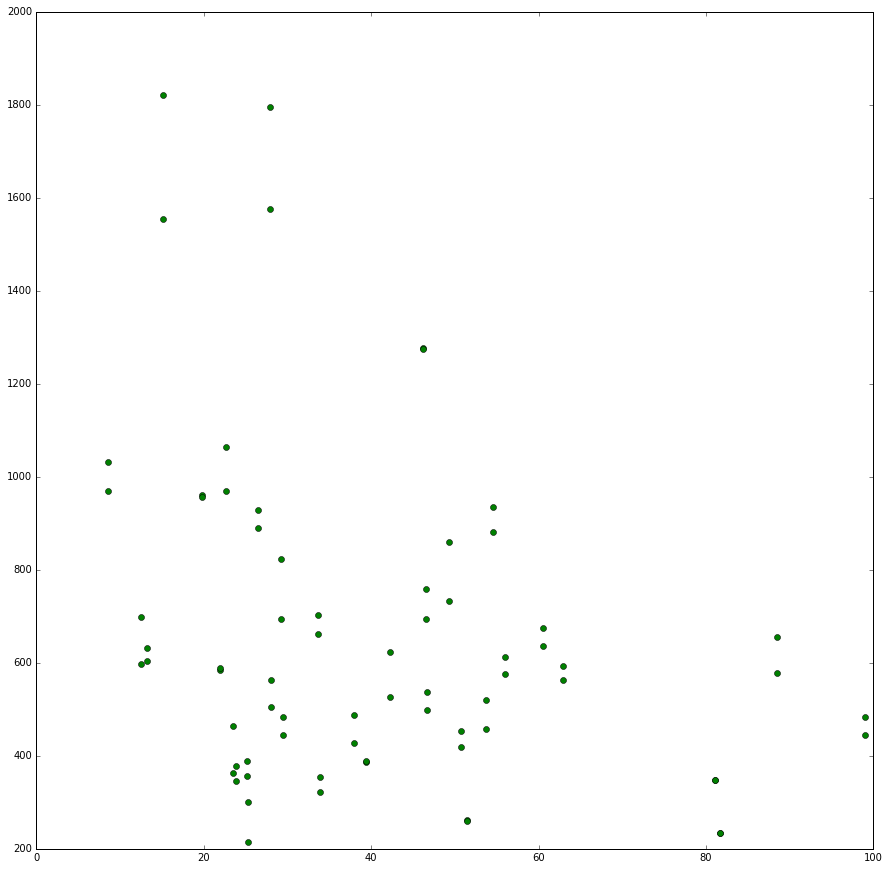

In [2089]:
fig = pl.figure(figsize = (15, 15))

pl.plot(data7.Pop_Dens, data7['NUMBER OF PERSONS INJURED'], 'go')

In [1906]:
variable_list = [x for x in variables if x not in not_variables]

In [1907]:
all_eqt = 'Injuries_Per_Thou ~ ' + ' + '.join(variable_list)

In [1908]:
above_thresh = with_projects_area[with_projects_area.Total_Pop > threshold]

In [1909]:
cols = [x.replace(' ', '_') for x in list(above_thresh.columns)]
cols = [x.replace('(', '_') for x in cols]
cols = [x.replace(')', '_') for x in cols]
cols = [x.replace('.', '_') for x in cols]
cols = [x.replace('/', '_') for x in cols]
cols = [x.replace('-', '_') for x in cols]
cols = [x.replace(',', '') for x in cols]
above_thresh.columns = cols
variables = list(above_thresh.columns)

In [1910]:
above_thresh.loc[:, 'Taxis':'Traf_Total'] = above_thresh.loc[:, 'Taxis':'Traf_Total'].apply(lambda x: x / above_thresh.Shape_Area)

In [1986]:
not_variables = ['PrecinctYear', 'Precinct', 'Year', 'NUMBER_OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 
                 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 
                 'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED', 'Shape_Area', 'Shape_Le_1', 'Shape_Leng','geometry','Injuries_Per_Thou', 
                 'Per_Thou_Inj_Change', 'VZ_Priority_Geo_i', 'Vision_Zero_i',  'VZ_Priority_Geo_c', 'Vision_Zero_c',
                'standardized_injuries', 'standardized_death', 'standardized_injuries_change', 'Total_Pop']
not_variables = [x.replace(' ', '_') for x in not_variables]
not_variables = [x.replace('(', '_') for x in not_variables]
not_variables = [x.replace(')', '_') for x in not_variables]

In [1987]:
all_regressors = 'Per_Thou_Inj_Change ~ ' + ' + '.join([x for x in variables if x not in not_variables])

In [1988]:
all_regressors = str(all_regressors)

In [1989]:
all_regressors

'Per_Thou_Inj_Change ~ Taxis + Flyers + Seniors + Outreach + HandsOn + Edu_Total + Backing_Unsafely + Brake_Lights__Defect_or_Improper_ + Bus_Lane_Driving_in + Cell_Phone + Commercial_Veh_on_Pkwy + Defective_Brakes + Disobey_Steady_Red_Signal + Disobey_Traffic_Control_Device + Equipment__Other_ + Fail_to_Keep_Right + Fail_to_Signal + Following_Too_Closely + Headlights__Defect__or_Improper_ + Improper_Lights + Improper_Passing + Improper_Turn + Improper_Missing_Plates + Not_Giving_R_of_W_to_Pedes_ + Not_Giving_R_of_W_to_Veh_ + One_Way_Street + Other_Movers + Pavement_Markings + Safety_Belt + School_Bus_Passing_Stopped + Speeding + Spillback + Tinted_Windows + Truck_Routes + U_Turn + Uninspected + Uninsured + Unlicensed_Operator + Unregistered + P12 + P123 + Traf_Total + Neigh_Slow_Zone_Total + Speed_Bump_Total + High_Crash_Corridor_c + New_Public_Space_c + Pedestrian_Safety_c + Senior_Safety_c + Traffic_Calming_c + Traffic_Network_Chng_c + Bikes_c + High_Crash_Corridor_i + Pedestrian_Sa

In [1990]:
df = above_thresh[above_thresh.Year > 2013]
df.reset_index(drop = True, inplace = True)
all_lm = smf.ols(all_regressors, df).fit()

In [1991]:
all_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.407
Model:                             OLS   Adj. R-squared:                  0.090
Method:                  Least Squares   F-statistic:                     1.282
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):              0.146
Time:                         17:47:55   Log-Likelihood:                 192.46
No. Observations:                  150   AIC:                            -278.9
Df Residuals:                       97   BIC:                            -119.4
Df Model:                           52                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.0286      0.018     -1.605      0.112        -0.064     0.007
Taxis                                 0.0043      0.008      0.540      0.590        -0.011     0.020
Flyers                               -0.0106      0.008     -1.276      0.205        -0.027     0.006
Seniors                               0.0052      0.007      0.721      0.473        -0.009     0.019
Outreach                             -0.0037      0.005     -0.775      0.440        -0.013     0.006
HandsOn                               0.0083      0.010      0.789      0.432        -0.012     0.029
Edu_Total                             0.0034      0.003      1.153      0.252        -0.002     0.009
Backing_Unsafely                      0.0002      0.001      0.138      0.890        -0.003     0.003
Brake_Lights__Defect_or_Improper_    -0.0006      0.000     -1.979      0.051        -0.001  1.74e-06
Bus_Lane_Driving_in                   0.0014      0.001      1.908      0.059     -5.74e-05     0.003
Cell_Phone                           -0.0002      0.000     -0.775      0.440        -0.001     0.000
Commercial_Veh_on_Pkwy            -3.828e-05      0.002     -0.020      0.984        -0.004     0.004
Defective_Brakes                      0.0030      0.004      0.795      0.429        -0.005     0.011
Disobey_Steady_Red_Signal             0.0001      0.000      0.412      0.682        -0.000     0.001
Disobey_Traffic_Control_Device        0.0001      0.000      0.462      0.645        -0.000     0.001
Equipment__Other_                     0.0004      0.000      1.133      0.260        -0.000     0.001
Fail_to_Keep_Right                   -0.0011      0.003     -0.380      0.705        -0.007     0.005
Fail_to_Signal                    -8.039e-05      0.000     -0.560      0.577        -0.000     0.000
Following_Too_Closely                 0.0007      0.002      0.309      0.758        -0.004     0.005
Headlights__Defect__or_Improper_  -4.486e-05      0.000     -0.142      0.887        -0.001     0.001
Improper_Lights                      -0.0002      0.000     -0.671      0.504        -0.001     0.000
Improper_Passing                     -0.0004      0.000     -1.081      0.282        -0.001     0.000
Improper_Turn                         0.0001      0.000      0.471      0.639        -0.000     0.001
Improper_Missing_Plates              -0.0014      0.001     -2.074      0.041        -0.003 -6.13e-05
Not_Giving_R_of_W_to_Pedes_           0.0002      0.000      1.829      0.070     -1.89e-05     0.000
Not_Giving_R_of_W_to_Veh_            -0.0002      0.000     -0.617      0.539        -0.001     0.001
One_Way_Street                       -0.0002      0.000     -0.519      0.605        -0.001     0.001
Other_Movers

In [1992]:
sig_var_all = all_lm.pvalues[all_lm.pvalues < .1].keys() 
sig_eqt_all = 'Per_Thou_Inj_Change ~ ' + ' + '.join(sig_var_all[1:])
lm_sig_all = smf.ols(sig_eqt_all, df).fit()
lm_sig_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.073
Model:                             OLS   Adj. R-squared:                  0.041
Method:                  Least Squares   F-statistic:                     2.269
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):             0.0507
Time:                         17:48:11   Log-Likelihood:                 158.92
No. Observations:                  150   AIC:                            -305.8
Df Residuals:                      144   BIC:                            -287.8
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0590      0.011     -5.510      0.000        -0.080    -0.038
Bus_Lane_Driving_in             0.0003      0.000      0.778      0.438        -0.000     0.001
Improper_Missing_Plates        -0.0008      0.000     -1.922      0.057        -0.002  2.14e-05
Not_Giving_R_of_W_to_Pedes_ -1.327e-05   2.07e-05     -0.642      0.522     -5.41e-05  2.76e-05
Speed_Bump_Total               -0.0036      0.003     -1.339      0.183        -0.009     0.002
Pedestrian_Safety_c            -0.0027      0.003     -0.872      0.384        -0.009     0.003
==============================================================================
Omnibus:                        4.115   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                3.872
Skew:                           0.393   Prob(JB):                        0.144
Kurtosis:                       3.049   Cond. No.                         715.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1993]:
danger_neighbors = df[df.Injuries_Per_Thou > mean_per_thou_inj]

In [1994]:
danger_all = smf.ols(all_regressors, danger_neighbors).fit()
danger_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.906
Model:                             OLS   Adj. R-squared:                  0.523
Method:                  Least Squares   F-statistic:                     2.365
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):             0.0530
Time:                         17:48:29   Log-Likelihood:                 139.63
No. Observations:                   62   AIC:                            -179.3
Df Residuals:                       12   BIC:                            -72.90
Df Model:                           49                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Intercept                             0.0005      0.038      0.014      0.989        -0.082     0.083
Taxis                                 0.0280      0.021      1.360      0.199        -0.017     0.073
Flyers                               -0.0368      0.030     -1.218      0.247        -0.103     0.029
Seniors                               0.0705      0.027      2.647      0.021         0.012     0.129
Outreach                             -0.0005      0.014     -0.034      0.974        -0.031     0.030
HandsOn                              -0.0435      0.026     -1.673      0.120        -0.100     0.013
Edu_Total                             0.0177      0.009      2.075      0.060        -0.001     0.036
Backing_Unsafely                     -0.0054      0.006     -0.920      0.376        -0.018     0.007
Brake_Lights__Defect_or_Improper_    -0.0014      0.001     -1.030      0.323        -0.004     0.002
Bus_Lane_Driving_in                   0.0046      0.002      1.915      0.080        -0.001     0.010
Cell_Phone                           -0.0007      0.001     -0.664      0.520        -0.003     0.001
Commercial_Veh_on_Pkwy                0.0051      0.005      1.026      0.325        -0.006     0.016
Defective_Brakes                      0.0264      0.009      2.902      0.013         0.007     0.046
Disobey_Steady_Red_Signal             0.0011      0.001      0.955      0.358        -0.001     0.004
Disobey_Traffic_Control_Device        0.0007      0.001      0.731      0.479        -0.001     0.003
Equipment__Other_                    -0.0009      0.003     -0.334      0.745        -0.007     0.005
Fail_to_Keep_Right                   -0.0177      0.012     -1.482      0.164        -0.044     0.008
Fail_to_Signal                       -0.0019      0.001     -2.270      0.042        -0.004 -7.54e-05
Following_Too_Closely                 0.0055      0.007      0.750      0.468        -0.010     0.021
Headlights__Defect__or_Improper_     -0.0010      0.001     -0.863      0.405        -0.004     0.002
Improper_Lights                      -0.0020      0.002     -1.312      0.214        -0.005     0.001
Improper_Passing                     -0.0018      0.001     -1.993      0.070        -0.004     0.000
Improper_Turn                         0.0005      0.001      0.501      0.626        -0.002     0.003
Improper_Missing_Plates              -0.0081      0.003     -2.722      0.019        -0.015    -0.002
Not_Giving_R_of_W_to_Pedes_       -1.806e-05      0.000     -0.044      0.966        -0.001     0.001
Not_Giving_R_of_W_to_Veh_             0.0013      0.001      1.061      0.310        -0.001     0.004
One_Way_Street                       -0.0022      0.001     -1.579      0.140        -0.005     0.001
Other_Movers

In [1995]:
danger_sig_var_all = danger_all.pvalues[danger_all.pvalues < .1].keys() 
danger_sig_eqt_all = 'Per_Thou_Inj_Change ~ ' + ' + '.join(danger_sig_var_all[1:])
danger_sig_all = smf.ols(danger_sig_eqt_all, df).fit()
danger_sig_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.122
Model:                             OLS   Adj. R-squared:                  0.059
Method:                  Least Squares   F-statistic:                     1.931
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):             0.0458
Time:                         17:48:35   Log-Likelihood:                 162.99
No. Observations:                  150   AIC:                            -304.0
Df Residuals:                      139   BIC:                            -270.9
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  -0.0490      0.013     -3.877      0.000        -0.074    -0.024
Edu_Total                   0.0014      0.002      0.911      0.364        -0.002     0.005
Bus_Lane_Driving_in         0.0005      0.000      1.316      0.190        -0.000     0.001
Defective_Brakes            0.0008      0.002      0.390      0.697        -0.003     0.005
Fail_to_Signal          -4.605e-05   4.82e-05     -0.955      0.341        -0.000  4.93e-05
Improper_Passing         1.548e-05      0.000      0.105      0.917        -0.000     0.000
Improper_Missing_Plates    -0.0008      0.000     -2.036      0.044        -0.002  -2.4e-05
Speeding                -9.289e-05   3.43e-05     -2.709      0.008        -0.000 -2.51e-05
Speed_Bump_Total           -0.0034      0.003     -1.242      0.216        -0.009     0.002
High_Crash_Corridor_c       0.0030      0.004      0.863      0.390        -0.004     0.010
Traffic_Calming_i          -0.0008      0.013     -0.058      0.954        -0.027     0.025
==============================================================================
Omnibus:                        4.130   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                4.189
Skew:                           0.397   Prob(JB):                        0.123
Kurtosis:                       2.799   Cond. No.                         766.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1984]:
df = danger_neighbors
X = df.loc[:, 'Taxis':'Traf_Total']
X = pd.concat([X, df.loc[:, 'New_Public_Space_c':'Traffic_Network_Chng_c'], df.loc[:, 'Bikes_c'], df.loc[:, 'Total_Pop'], 
               df.loc[:, 'Pedestrian_Safety_i':'Traffic_Network_Chng_i']], axis = 1)
y = df.Per_Thou_Inj_Change

In [2025]:
data7['speed_bump_sq'] = data7['Speed_Bump_Total'] ** 2

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [2032]:
lm = smf.ols('Per_Thou_Inj_Change ~ Speed_Bump_Total', data7).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.110
Model:                             OLS   Adj. R-squared:                  0.097
Method:                  Least Squares   F-statistic:                     8.620
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):            0.00450
Time:                         18:16:16   Log-Likelihood:                 82.745
No. Observations:                   72   AIC:                            -161.5
Df Residuals:                       70   BIC:                            -156.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0494      0.013     -3.887      0.000        -0.075    -0.024
Speed_Bump_Total    -0.0111      0.004     -2.936      0.004        -0.019    -0.004
==============================================================================
Omnibus:                        1.000   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                1.081
Skew:                           0.217   Prob(JB):                        0.582
Kurtosis:                       2.586   Cond. No.                         4.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

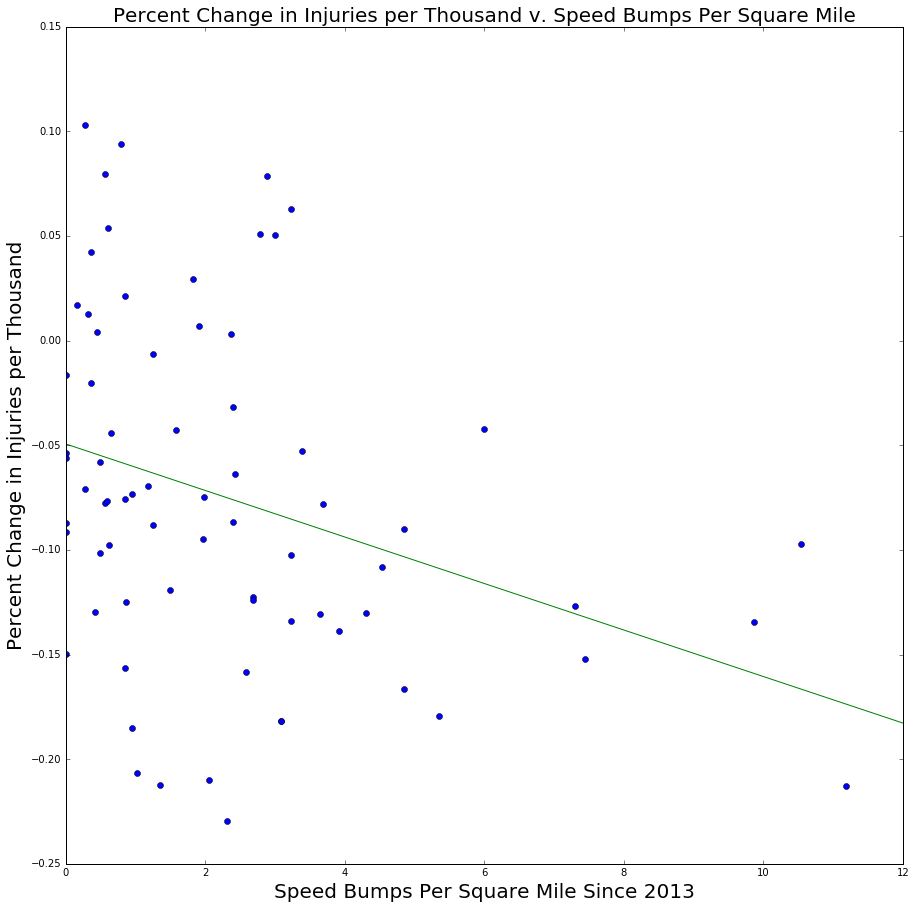

In [2033]:
pl.figure(figsize = (15,15))
pl.plot(data7.Speed_Bump_Total, data7.Per_Thou_Inj_Change, 'o')
pl.xlabel('Speed Bumps Per Square Mile Since 2013', fontsize = 20)
pl.ylabel('Percent Change in Injuries per Thousand', fontsize = 20)
pl.title('Percent Change in Injuries per Thousand v. Speed Bumps Per Square Mile', fontsize = 20)
x = pd.DataFrame({'Speed_Bump_Total': np.linspace(0, 12, 200)})

pl.plot(np.linspace(0, 12, 200), lm.predict(x))
pl.savefig('Speed_Bumps_Change.png', format = 'png')

In [2020]:
x = pd.DataFrame({'Speed_Bump_Total': np.linspace(0, 12, 50)})

In [2021]:
lm.predict(x)

array([-0.04937421, -0.05209563, -0.05481704, -0.05753846, -0.06025988,
       -0.06298129, -0.06570271, -0.06842412, -0.07114554, -0.07386696,
       -0.07658837, -0.07930979, -0.0820312 , -0.08475262, -0.08747404,
       -0.09019545, -0.09291687, -0.09563828, -0.0983597 , -0.10108112,
       -0.10380253, -0.10652395, -0.10924537, -0.11196678, -0.1146882 ,
       -0.11740961, -0.12013103, -0.12285245, -0.12557386, -0.12829528,
       -0.13101669, -0.13373811, -0.13645953, -0.13918094, -0.14190236,
       -0.14462377, -0.14734519, -0.15006661, -0.15278802, -0.15550944,
       -0.15823085, -0.16095227, -0.16367369, -0.1663951 , -0.16911652,
       -0.17183793, -0.17455935, -0.17728077, -0.18000218, -0.1827236 ])

In [1937]:
lm_speed = smf.ols('Per_Thou_Inj_Change ~ Speed_Bump_Total', data7).fit()
lm_speed.predict

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.110
Model:                             OLS   Adj. R-squared:                  0.097
Method:                  Least Squares   F-statistic:                     8.620
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):            0.00450
Time:                         15:07:46   Log-Likelihood:                 82.745
No. Observations:                   72   AIC:                            -161.5
Df Residuals:                       70   BIC:                            -156.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0494      0.013     -3.887      0.000        -0.075    -0.024
Speed_Bump_Total    -0.0111      0.004     -2.936      0.004        -0.019    -0.004
==============================================================================
Omnibus:                        1.000   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                1.081
Skew:                           0.217   Prob(JB):                        0.582
Kurtosis:                       2.586   Cond. No.                         4.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

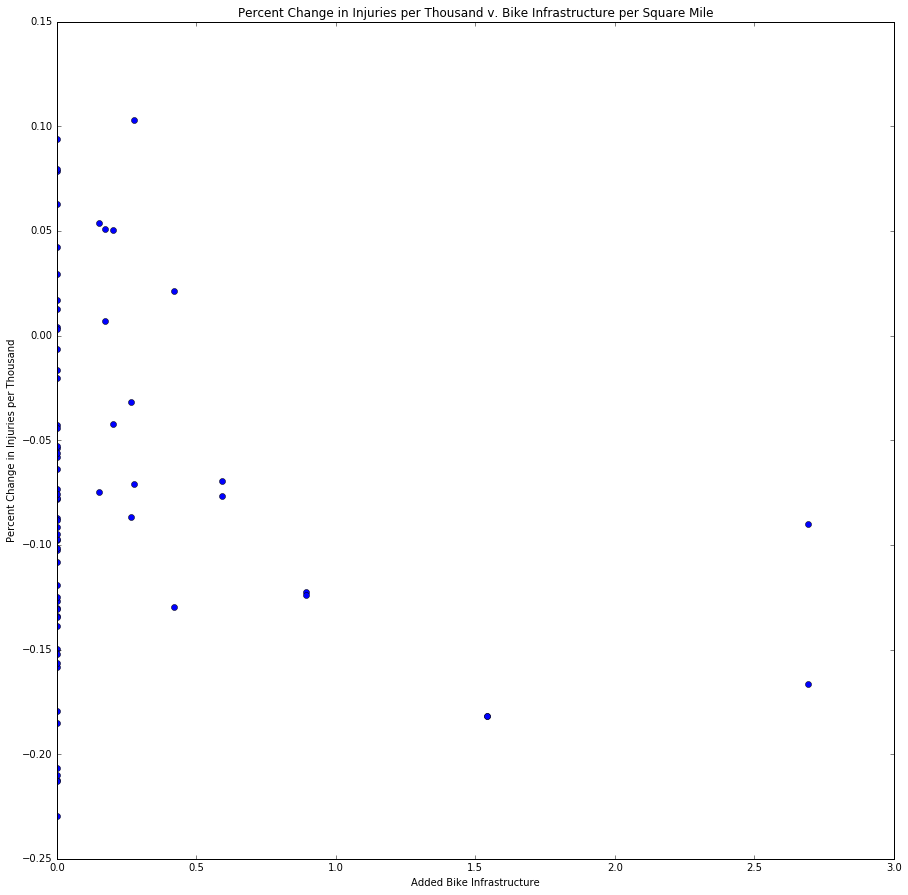

In [1973]:
pl.figure(figsize = (15,15))
pl.plot(data7.Traffic_Calming_i, data7.Per_Thou_Inj_Change, 'o')
pl.xlabel('Added Bike Infrastructure')
pl.ylabel('Percent Change in Injuries per Thousand')
pl.title('Percent Change in Injuries per Thousand v. Bike Infrastructure per Square Mile')

In [2044]:
all_regressors

'Per_Thou_Inj_Change ~ Taxis + Flyers + Seniors + Outreach + HandsOn + Edu_Total + Backing_Unsafely + Brake_Lights__Defect_or_Improper_ + Bus_Lane_Driving_in + Cell_Phone + Commercial_Veh_on_Pkwy + Defective_Brakes + Disobey_Steady_Red_Signal + Disobey_Traffic_Control_Device + Equipment__Other_ + Fail_to_Keep_Right + Fail_to_Signal + Following_Too_Closely + Headlights__Defect__or_Improper_ + Improper_Lights + Improper_Passing + Improper_Turn + Improper_Missing_Plates + Not_Giving_R_of_W_to_Pedes_ + Not_Giving_R_of_W_to_Veh_ + One_Way_Street + Other_Movers + Pavement_Markings + Safety_Belt + School_Bus_Passing_Stopped + Speeding + Spillback + Tinted_Windows + Truck_Routes + U_Turn + Uninspected + Uninsured + Unlicensed_Operator + Unregistered + P12 + P123 + Traf_Total + Neigh_Slow_Zone_Total + Speed_Bump_Total + High_Crash_Corridor_c + New_Public_Space_c + Pedestrian_Safety_c + Senior_Safety_c + Traffic_Calming_c + Traffic_Network_Chng_c + Bikes_c + High_Crash_Corridor_i + Pedestrian_Sa

In [2050]:
street_design = ['Neigh_Slow_Zone_Total', 'Speed_Bump_Total', 'New_Public_Space_c', 
                 'Pedestrian_Safety_c', 'Senior_Safety_c', 'Traffic_Calming_c', 'Traffic_Network_Chng_c', 'Bikes_c',
                 'Pedestrian_Safety_i', 'Senior_Safety_i','Traffic_Calming_i', 'Traffic_Network_Chng_i']

In [2052]:
for design in street_design: 
    equation = 'Per_Thou_Inj_Change ~ ' + design
    lm = smf.ols(equation, data6[data6[design] > 0]).fit()
    print lm.summary()

                             OLS Regression Results                            
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.028
Model:                             OLS   Adj. R-squared:                 -0.015
Method:                  Least Squares   F-statistic:                    0.6517
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):              0.428
Time:                         19:51:39   Log-Likelihood:                 27.072
No. Observations:                   25   AIC:                            -50.14
Df Residuals:                       23   BIC:                            -47.71
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept           

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n))
/opt/rh/anaconda/root/lib/python2.7/site-packages/scipy/stats/stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


In [2075]:
lm = smf.ols('Per_Thou_Inj_Change ~ Traffic_Calming_i', data = data6[data6.Traffic_Calming_i >0]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Per_Thou_Inj_Change   R-squared:                       0.116
Model:                             OLS   Adj. R-squared:                  0.090
Method:                  Least Squares   F-statistic:                     4.479
Date:                 Fri, 09 Dec 2016   Prob (F-statistic):             0.0417
Time:                         20:34:28   Log-Likelihood:                 41.085
No. Observations:                   36   AIC:                            -78.17
Df Residuals:                       34   BIC:                            -75.00
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -0.0325      0.019     -1.724      0.094        -0.071     0.006
Traffic_Calming_i    -0.0336      0.016     -2.116      0.042        -0.066    -0.001
==============================================================================
Omnibus:                        0.495   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.781   Jarque-Bera (JB):                0.497
Skew:                           0.252   Prob(JB):                        0.780
Kurtosis:                       2.723   Cond. No.                         2.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2084]:
above_thresh['Pop_Dens'] = above_thresh.Total_Pop / above_thresh.Shape_Area / 1000

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [2093]:
lm = smf.ols('standardized_injuries ~ Pop_Dens + Speed_Bump_Total + Traffic_Calming_i + Bikes_c', data7).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     standardized_injuries   R-squared:                       0.274
Model:                               OLS   Adj. R-squared:                  0.230
Method:                    Least Squares   F-statistic:                     6.308
Date:                   Fri, 09 Dec 2016   Prob (F-statistic):           0.000228
Time:                           21:00:27   Log-Likelihood:                -98.800
No. Observations:                     72   AIC:                             207.6
Df Residuals:                         67   BIC:                             219.0
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             1.0912      0.257      4.252      0.000         0.579     1.603
Pop_Dens             -0.0123      0.006     -2.175      0.033        -0.024    -0.001
Speed_Bump_Total     -0.1067      0.051     -2.096      0.040        -0.208    -0.005
Traffic_Calming_i     0.5426      0.237      2.286      0.025         0.069     1.016
Bikes_c              -0.1350      0.038     -3.540      0.001        -0.211    -0.059
==============================================================================
Omnibus:                       25.184   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.956
Skew:                           1.379   Prob(JB):                     3.47e-09
Kurtosis:                       5.318   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2086]:
above_thresh.Pop_Dens

0      31.294416
1      31.294416
2      31.294416
3      30.159623
4      30.159623
5      30.159623
6      29.505852
7      29.505852
8      29.505852
9      49.617901
10     49.617901
11     49.617901
12     25.253405
13     25.253405
14     25.253405
15     42.933673
16     42.933673
17     42.933673
18     82.955788
19     82.955788
20     82.955788
21     20.784179
22     20.784179
23     20.784179
24     46.229287
25     46.229287
26     46.229287
27     37.893001
28     37.893001
29     37.893001
         ...    
201    21.086200
202    21.086200
203    21.086200
204    99.611034
205    99.611034
206    99.611034
207    57.907496
208    57.907496
209    57.907496
210    42.350991
211    42.350991
212    42.350991
213    32.973566
214    32.973566
215    32.973566
216    62.957534
217    62.957534
218    62.957534
219    23.894052
220    23.894052
221    23.894052
222    12.468349
223    12.468349
224    12.468349
225    99.046059
226    99.046059
227    99.046059
228    60.4863